In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import shutil
import time
import tensorflow as tf
from tensorflow import keras
# import keras

print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

sys.version_info(major=3, minor=7, micro=3, releaselevel='final', serial=0)
matplotlib 3.0.3
numpy 1.16.2
pandas 0.24.2
sklearn 0.21.1
tensorflow 2.0.0-alpha0
tensorflow.python.keras.api._v2.keras 2.2.4-tf


In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [3]:
# x = (x - u) / std

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# x_train: [None, 28, 28] -> [None, 784]
x_train_scaled = scaler.fit_transform(x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_valid_scaled = scaler.transform(x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_test_scaled = scaler.transform(x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)

In [4]:
# tf.keras.models.Sequential()

model = tf.keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation='selu'))
model.add(keras.layers.Dense(10, activation='softmax'))


# relu: y = max(0, x)
# softmax: 将向量变成概率分布. x = [x1, x2, x3],
#          y = [e^x1/sum, e^x2/sum, e^x3/sum], sum = e^x1 + e^x2 + e^x3

# reason for sparse: y->index. y->one_hot->[]
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='sgd', 
              metrics=['accuracy'])

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               1

In [6]:
# TensorBoard, EarlyStopping, ModelCheckpoint
log_dir = './tmp/dnn-selu-callbacks'
if os.path.exists(log_dir):
    shutil.rmtree(log_dir)
    os.mkdir(log_dir)
else:
    os.mkdir(log_dir)
    
output_model_file = os.path.join(log_dir, 'fashion_mnist_model.h5')
callbacks = [
    keras.callbacks.TensorBoard(log_dir),
    keras.callbacks.ModelCheckpoint(output_model_file, save_best_only=True),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3)
]
history = model.fit(x_train_scaled, y_train, epochs=10, 
                    validation_data=[x_valid_scaled, y_valid], 
                    callbacks=callbacks)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 10s 183us/sample - loss: 0.6806 - accuracy: 0.7593 - val_loss: 0.5176 - val_accuracy: 0.8136
Epoch 2/10
55000/55000 [==============================] - 10s 176us/sample - loss: 0.4825 - accuracy: 0.8259 - val_loss: 0.4562 - val_accuracy: 0.8336
Epoch 3/10
55000/55000 [==============================] - 10s 174us/sample - loss: 0.4293 - accuracy: 0.8451 - val_loss: 0.4200 - val_accuracy: 0.8470
Epoch 4/10
55000/55000 [==============================] - 9s 172us/sample - loss: 0.3989 - accuracy: 0.8566 - val_loss: 0.3953 - val_accuracy: 0.8556
Epoch 5/10
55000/55000 [==============================] - 9s 172us/sample - loss: 0.3771 - accuracy: 0.8630 - val_loss: 0.3950 - val_accuracy: 0.8540
Epoch 6/10
55000/55000 [==============================] - 9s 171us/sample - loss: 0.3592 - accuracy: 0.8695 - val_loss: 0.3875 - val_accuracy: 0.8618
Epoch 7/10
55000/55000 [========================

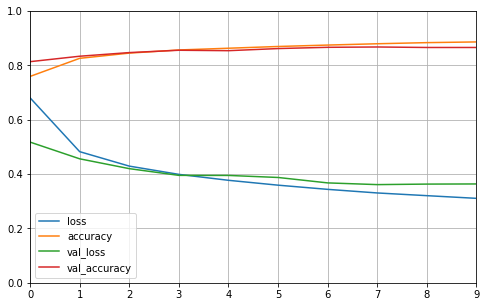

In [7]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()
    
plot_learning_curves(history)

# 1. 参数众多， 训练不充分
# 2. 梯度消失 -> 链式法则 -> 复合函数f(g(x))
#    批归一化缓解梯度消失

In [8]:
model.evaluate(x_test_scaled, y_test)

10000/10000 [==============================] - 1s 75us/sample - loss: 0.4083 - accuracy: 0.8523


[0.40827181742191315, 0.8523]